# Global Regression Analysis
Taking a look at what comes out from the global regression.

**NOTE**: The native grid output does not plot well globally, especially for contour mapping. Thus, I've embedded a cdo function to temporarily remap the output of interest to a 1deg by 1deg standard grid globally.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

import cmocean.cm as cm
import cartopy.crs as ccrs
import esmtools as et

In [2]:
def meshgrid(x, y, d):
    (xx, yy) = np.meshgrid(x, y)
    d.coords['gridlon'] = (('lat', 'lon'), xx)
    d.coords['gridlat'] = (('lat', 'lon'), yy)
    return d

In [3]:
ebu_names = {
    'CalCS': 'California Current',
    'CanCS': 'Canary Current',
    'BenCS': 'Benguela Current',
    'HumCS': 'Humboldt Current',
}

# Single Global View

Pick a system, variable, member, and smoothing.

In [74]:
EBU = 'BenCS'
VAR = 'curl'
LAG = 0
SMOOTHED = False

In [75]:
if SMOOTHED:
    filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/global_regressions/' + VAR + '/' +
                EBU + '/lag' + str(LAG) + '/*smoothed*.nc')
else:
    filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/global_regressions/' + VAR + '/' +
                EBU + '/lag' + str(LAG) + '/*unsmoothed*.nc')

In [76]:
ds = xr.open_mfdataset(filepath, concat_dim='simulation')
ds = ds.where(ds.p <= 0.05) # Mask out insignificant
ds = ds.mean(dim='simulation') # Ensemble composite
ds = meshgrid(ds.lon, ds.lat, ds)
lon, lat, data = et.vis.deseam(ds.gridlon, ds.gridlat, ds.r)

/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [77]:
# Colormap
cmap = plt.cm.BrBG_r
cmap.set_under('#a9a9a9')

# Contour levels (only 0.3 - 1 and -1 to -0.3.)
lower = np.linspace(-1, -0.3, 8)
upper = np.linspace(0.3, 1, 8)
levels = np.append(lower, upper)

/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


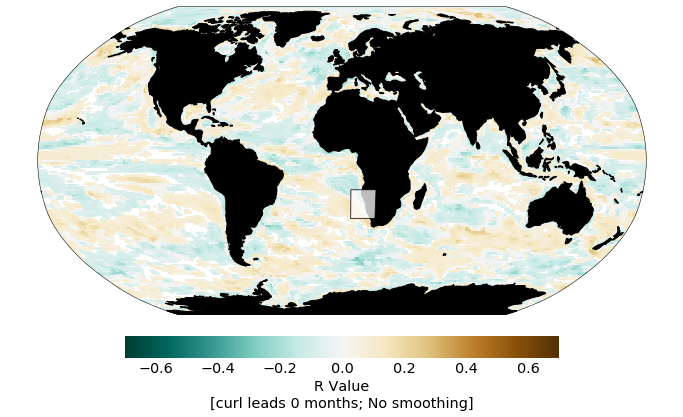

In [78]:
if (EBU == "HumCS") or (EBU == "CalCS"):
    f, ax = et.vis.make_cartopy(projection=ccrs.Robinson(central_longitude=180),
                            grid_lines=False, figsize=(12,8), frameon=True)
else:
    f, ax = et.vis.make_cartopy(projection=ccrs.Robinson(central_longitude=0),
                            grid_lines=False, figsize=(12,8), frameon=True)
    
# Forgot to flip the sign when making the global residuals
if VAR == "FG_ALT_CO2":
    data = data * -1

# Pcolor background.
plt.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
               vmin=-0.7, vmax=0.7, cmap=cmap)
cb = plt.colorbar(orientation='horizontal', pad=0.05, fraction=0.05)

# Contours.
cs = ax.contour(ds.gridlon, ds.gridlat, ds.r, transform=ccrs.PlateCarree(),
                linewidths=1, colors='k', levels=levels)
fmt = '%.2f'
labels = plt.clabel(cs, fontsize=10, inline=1, fmt=fmt)

# Box.
x0, x1, y0, y1 = et.ebus.visual_bounds(EBU, std_lon=True)
et.vis.add_box(ax, x0, x1, y0, y1, facecolor='w', edgecolor='k',
               linewidth=2, alpha=0.75, zorder=3)

# Labels.
#ax.set_title('Global ' + VAR + ' Correlation with F$_{\mathrm{Nat}}$' +
#             ' in the ' + ebu_names[EBU])
cb.set_label('R Value' + '\n' + '[' + VAR + ' leads ' + str(LAG) + ' months; No smoothing]')

# Zoom in...
#x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)
#ax.set_extent([x0,x1,y0,y1])

plt.show()

# Composite with lags 0-5

In [32]:
def load_lag_composite(var, ebu, lag):
    """
    Given the variable, system, and lag, this will composite whatever simulations have been remapped
    and returns a dataset with a filter of only p <= 0.05 shown and a meshgrid lat/lon.
    """
    if SMOOTHED:
        filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/global_regressions/' + var + '/' +
                    ebu + '/lag' + str(lag) + '/*smoothed*.nc')
    else:
        filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/global_regressions/' + var + '/' +
                    ebu + '/lag' + str(lag) + '/*unsmoothed*.nc')
    ds = xr.open_mfdataset(filepath, concat_dim='simulation')
    ds = ds.where(ds.p <= 0.05) # Mask out insignificant
    ds = ds.mean(dim='simulation') # Ensemble composite
    ds = meshgrid(ds.lon, ds.lat, ds)
    return ds

In [43]:
VAR = 'curl'
EBU = 'BenCS'
SMOOTH = False

In [44]:
# Load lagged 0 through 6 months
ds0 = load_lag_composite(VAR, EBU, 0)
ds1 = load_lag_composite(VAR, EBU, 1)
ds2 = load_lag_composite(VAR, EBU, 2)
ds3 = load_lag_composite(VAR, EBU, 3)
ds4 = load_lag_composite(VAR, EBU, 4)
ds5 = load_lag_composite(VAR, EBU, 5)

# Contour levels (only 0.3 - 1 and -1 to -0.3.)
lower = np.linspace(-1, -0.3, 8)
upper = np.linspace(0.3, 1, 8)
levels = np.append(lower, upper)

# Colormap
cmap = plt.cm.RdBu_r
cmap.set_under('#a9a9a9')

### Visualization

/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


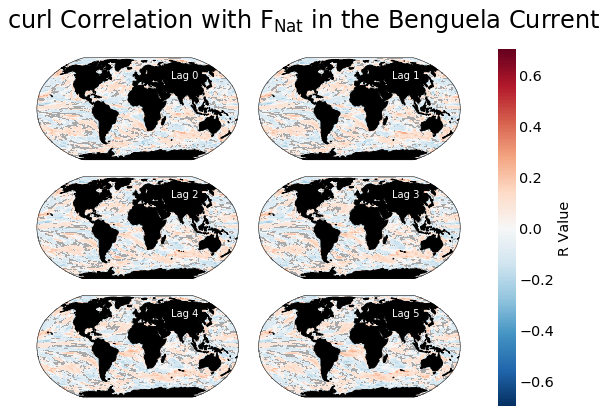

In [45]:
import cartopy.feature as cfeature
import matplotlib as mpl

if (EBU == "HumCS") or (EBU == "CalCS"):
    f, axes = plt.subplots(nrows=3, ncols=2,
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=180)},
                       gridspec_kw = {'wspace':0, 'hspace':0},
                       figsize=(8,6))
else:
    f, axes = plt.subplots(nrows=3, ncols=2,
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                       gridspec_kw = {'wspace':0, 'hspace':0},
                       figsize=(8,6))
    
if VAR == "FG_ALT_CO2":
    ds['r'] = ds['r'] * -1
# Main title.
st = f.suptitle(VAR + ' Correlation with F$_{\mathrm{Nat}}$ in the ' +
                  ebu_names[EBU], fontsize=24)

for i, ax in enumerate(axes.flat):
    # Projection Aesthetics
    ax.outline_patch.set_edgecolor('k')
    ax.add_feature(cfeature.LAND, facecolor='k')
    
    # P-Color R values
    ds = eval('ds' + str(i))
    p = ax.pcolormesh(ds['gridlon'], ds['gridlat'], ds['r'], transform=ccrs.PlateCarree(),
                  vmin=-0.7, vmax=0.7, cmap=cmap)
    
    # Contours
    cs = ax.contour(ds['gridlon'], ds['gridlat'], ds['r'], transform=ccrs.PlateCarree(),
                    linewidths=1, colors='k', levels=levels)
    
    # Labels
    ax.text(67, 48, 'Lag ' + str(i), color='w', transform=ccrs.Geodetic())

# Tight layout + subplot adjustment
f.tight_layout()
f.subplots_adjust(top=0.85)
st.set_y(0.95)

# Colorbar
cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
cb = plt.colorbar(p, cax=cax, **kw)
cb.set_label('R Value')

plt.show()